In [1]:
%matplotlib widget
import sys
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/')
sys.path.append('/home/massoale/Stage_M2/Analyse/Stage_M2-main/stage_diags/diagnostics_pkg/.ipynb_checkpoints')
sys.path.append('/home/massoale/Stage_M2/Analyse/qgutils-master/')
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc
import io_utils as io
import operators as op
import qgutils as qg
import xarray as xr
import scipy as sp
import pandas as pd

# Selecting the simulations

In [41]:
#Number of simulation you want to load

#Periodic Simu
#simu_numbers=np.array([59,49,51,52,53,54,63,64,68,67,70,69,68,619]) #301,302,303,304,305,313,314,315,316,320,321,207
#simu_numbers=np.array([51,63,60,67,69,65,70,62,71,72,74]+[83,84,85,116,153,154,210,309,610,317,318,619])
#Non Periodic Simu
#simu_numbers=np.array([83,84,85,116,153,154,210,309,610,317,318,319,519]+[n for n in range(105,110)])
simu_numbers=np.array([83,84,116,153,154,210,317,318,319,519,922,923,612,610]+[n for n in range(105,110)]) #CONVERGING MORE THAN 90%
#simu_numbers=np.array([83,84,116,153,154,210,317,318,319,519,922,923,612,610,91,307,85]+[n for n in range(101,110)]+[207,301, 302, 303, 304, 305,306,321,320,611,313,314,315,316]) #ALLL SIMUUU


simu_name_tab=np.array([f'String {num}' for num in simu_numbers])

#Time to start the velovity field storage
tstart=-20

#Arrays where I will store the parameters:

kh_E_tab= np.zeros_like(simu_numbers,dtype='float') 
k_f_tab= np.zeros_like(simu_numbers,dtype='float')
k_beta_tab= np.zeros_like(simu_numbers,dtype='float')
Z_tab=np.zeros_like(simu_numbers,dtype='float')
KbetaOL_tab=np.zeros_like(simu_numbers,dtype='float')
Oc_tab_l=np.zeros_like(simu_numbers,dtype='float')
Zo_tab_l=np.zeros_like(simu_numbers,dtype='float')
E_zonal_tab=np.zeros_like(simu_numbers,dtype='float')
E_mean_tab=np.zeros_like(simu_numbers,dtype='float')
jet_size_tab=np.zeros_like(simu_numbers,dtype='float')
rhines_length_tab=np.zeros_like(simu_numbers,dtype='float')


f0_tab=np.zeros_like(simu_numbers,dtype='float')
beta_tab=np.zeros_like(simu_numbers,dtype='float')
hEkb_tab=np.zeros_like(simu_numbers,dtype='float')
dh_tab=np.zeros_like(simu_numbers,dtype='float')
Lx_tab=np.zeros_like(simu_numbers,dtype='float')
nx_tab=np.zeros_like(simu_numbers,dtype='float')
ny_tab=np.zeros_like(simu_numbers,dtype='float')
sigma_f_tab=np.zeros_like(simu_numbers,dtype='float')
bc_fac_tab=np.zeros_like(simu_numbers,dtype='float')
nu_hyper_tab=np.zeros_like(simu_numbers,dtype='float')
n_hyper_tab=np.zeros_like(simu_numbers,dtype='float')

E_diss_jet=np.zeros_like(simu_numbers,dtype='float')
E_diss_tot=np.zeros_like(simu_numbers,dtype='float')
Area_tot=np.zeros_like(simu_numbers,dtype='float')

time_jet=np.zeros_like(simu_numbers,dtype='float')
time_nl=np.zeros_like(simu_numbers,dtype='float')

#Choose between 'local' or 'dahu'
where='dahu'


#Reading the netcdf file

for i,n in enumerate(simu_numbers):
    
    # Reading the netcdf file
    if where == 'local':
        if n < 10:
            simu_name = 'outdir_000' + str(n)
        elif n < 100 and n >= 10:
            simu_name = 'outdir_00' + str(n)
        Path = '/home/massoale/Simu_Test/qgw-main/src/' + simu_name + '/'
    elif where == 'dahu':
        simu_name = 'dahu_' + str(n)
        Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

    elif where == 'dahu_downsized':
        simu_name = 'dahu_' + str(n)
        Path = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_downsized/'
        Path_bis = '/home/massoale/Simu_Test/simu_dahu/simu_dahu' + str(n) + '/outdir_0001/'

    else:
        print('Error: where not recognized')
        sys.exit()

    print('la simulation chargée est: ' + simu_name)
    print("depuis: " + where)

    filenames = ['/vars.nc']

    # Open the dataset using xarray
    dataset = xr.open_dataset(Path + filenames[0],chunks={'time': 10})


    # Load variables in chunks
    t = dataset['time'].data
    x = dataset['x'].data
    y = dataset['y'].data
    psi = dataset['psi'].isel( level=0).data
    q = dataset['q'].isel(level=0).data
    print("shape of psi :",np.shape(psi))


    # Lecture des paramètres :
    if where == 'dahu_downsized':
        param = io.read_params(Path_bis)
        nx = 256
        ny = 256
        param['NX'] = nx
        param['NY'] = ny
    else:
        param = io.read_params(Path)
        nx = int(param['NX'])
        ny = int(param['NY'])

    f0 = param['f0']
    beta = param['beta']
    hEkb = param['hEkb']
    dh = param['dh'][0]
    Lx = param['Lx']
    k_f = param['k_f']
    sigma_f = param['sigma_f']
    bc_fac = param['bc_fac']
    nu_hyper = param['nu_hyper']
    n_hyper = param['n_hyper']
    dt_out = param['dt_out']
    

    epsilon=sigma_f**2
    r=f0*hEkb/(2*dh)
    
    #Calcul de kh_E
    kh_E=np.sqrt(r**3/epsilon)
    kh_E_tab[i]=kh_E

    #Calcul de k_beta
    k_beta=(beta**3/epsilon)**(1/5)
    k_beta_tab[i]=k_beta

    k_f_tab[i]=k_f

    #computing zonostrophy:

    Z_tab[i]= (beta**2*epsilon/(r**5))**(1/20)
    print('Zonostrophie:',Z_tab[i]) 
    
    #Computing Kbeta*L
    k_betar=beta**0.5/(epsilon/r)**(1/4)
    KbetaOL_tab[i]= 1/(k_betar*Lx)

    #Computin occupation and zonostrophy by the definition
    Oc_tab_l[i]= (epsilon/(beta**2*r*(Lx/(2*np.pi))**4))**(1/4) #k_Rh/k_L
    Zo_tab_l[i]= (beta**2*epsilon/r**5)**(1/20)

    #Storing the velocity field
    delta=Lx/nx

    u,v=op.calc_uv(psi[-50:,:,:],delta,bc_fac)
    

    #Mean energy
    energy_tot=np.mean(0.5*(u**2+v**2),axis=0)

    #Energy of the mean zonal flow
    energy_zonal=0.5*(np.mean(u,axis=0)**2)

    #Energy of the mean flow
    #FALSEenergy_mean=0.5*(np.mean(np.sqrt(u**2+v**2),axis=0)**2)

    energy_mean=0.5*(np.mean(u,axis=0)**2+np.mean(v,axis=0)**2)

    ratioUzonUtot=energy_zonal/energy_tot
    ratioUmeanUtot=energy_mean/energy_tot

    E_zonal_tab[i]=np.nanmean(ratioUzonUtot, axis=(0,1)) 
    E_mean_tab[i]=np.nanmean(ratioUmeanUtot, axis=(0,1))
    print(E_zonal_tab[i],E_mean_tab[i])


    #plotting the zonnaly averaged stream function with respect to the latitude
    
    psi_zonal_mean = np.mean(psi[-50:,:,:], axis=2)
    psi_zonal_mean_temp = np.mean(psi_zonal_mean, axis=0)

    
    q_zonal_mean = np.mean(q[-50:,:,:], axis=2)
    q_zonal_mean_temp = np.mean(q_zonal_mean, axis=0)

    zero_crossings = np.where(np.diff(np.sign(psi_zonal_mean_temp)))[0] # Find the zero crossings
    print(y[zero_crossings])
    jet_size_tab[i]=(y[zero_crossings][2]-y[zero_crossings][1]+y[zero_crossings][-2]-y[zero_crossings][-3])/2
    epsilon=sigma_f**2
    rhines_length_tab[i]=np.pi*2/(beta**0.5/(epsilon/r)**(1/4))
    
    psi_max=np.max(psi_zonal_mean_temp)
    
    #finding the indices where psi is greater than 20% of the maximum
    #indices=np.where(psi_zonal_mean_temp>0.2*psi_max)
    


    #Finding the lattitude of psi at the extremity of the jet
    #y_max=y[indices[0]]
    
   
    E_diss_tot[i]=-2*np.sum(energy_tot)*r
    Area_tot[i]=Lx**2
    

    #filling the arrays
    f0_tab[i]=f0
    beta_tab[i]=beta
    hEkb_tab[i]=hEkb
    dh_tab[i]=dh
    Lx_tab[i]=Lx
    nx_tab[i]=nx
    ny_tab[i]=ny
    sigma_f_tab[i]=sigma_f
    bc_fac_tab[i]=bc_fac
    nu_hyper_tab[i]=nu_hyper
    n_hyper_tab[i]=n_hyper
    
    U_phi=beta/k_betar**2
    time_nl[i]=Lx/U_phi
    time_jet[i]=1/r





la simulation chargée est: dahu_83
depuis: dahu
shape of psi : (2392, 513, 513)
Zonostrophie: 2.817585085135084


/tmp/ipykernel_84422/3234037269.py:165: RuntimeWarning: invalid value encountered in divide
  ratioUzonUtot=energy_zonal/energy_tot
/tmp/ipykernel_84422/3234037269.py:166: RuntimeWarning: invalid value encountered in divide
  ratioUmeanUtot=energy_mean/energy_tot


0.05667414624955726 0.07217216811479035
[0.         0.4049709  0.65040785 2.06167    2.0984857  2.6875343
 5.6818647  5.8413987  6.2709136 ]
la simulation chargée est: dahu_84
depuis: dahu
shape of psi : (645, 513, 513)
Zonostrophie: 3.592768096283483


/tmp/ipykernel_84422/3234037269.py:165: RuntimeWarning: invalid value encountered in divide
  ratioUzonUtot=energy_zonal/energy_tot
/tmp/ipykernel_84422/3234037269.py:166: RuntimeWarning: invalid value encountered in divide
  ratioUmeanUtot=energy_mean/energy_tot


0.16595562485924964 0.18061104500348524
[0.         0.67495155 0.94493216 2.0125828  5.3014374  5.620506
 6.2709136 ]
la simulation chargée est: dahu_116
depuis: dahu
shape of psi : (122, 2049, 2049)
Zonostrophie: 3.592768096283483


/tmp/ipykernel_84422/3234037269.py:165: RuntimeWarning: invalid value encountered in divide
  ratioUzonUtot=energy_zonal/energy_tot
/tmp/ipykernel_84422/3234037269.py:166: RuntimeWarning: invalid value encountered in divide
  ratioUmeanUtot=energy_mean/energy_tot


0.05804211645044427 0.06789341833863263
[ 0.          0.57064086  0.9111846   1.3805827   1.5462526   2.4390295
  2.6875343   3.0556898   3.34101     3.4882724   5.982525    6.2678456
  6.5899816   7.0869913   7.252661    9.415574    9.838953    9.90338
 10.786953   11.081477   11.412817   11.495652   11.744157   14.201594
 14.615769   14.85507    17.2941     17.561012   17.947575   18.278915
 18.840351  ]
la simulation chargée est: dahu_153
depuis: dahu
shape of psi : (287, 301, 301)
Zonostrophie: 2.7049497663184234


/tmp/ipykernel_84422/3234037269.py:165: RuntimeWarning: invalid value encountered in divide
  ratioUzonUtot=energy_zonal/energy_tot
/tmp/ipykernel_84422/3234037269.py:166: RuntimeWarning: invalid value encountered in divide
  ratioUmeanUtot=energy_mean/energy_tot


0.1328342050300885 0.14691385156778838
[0.         0.4712389  0.82728606 1.1414454  1.8640116  2.0734513
 2.4085543  2.6912978  3.1311207 ]
la simulation chargée est: dahu_154
depuis: dahu
shape of psi : (1060, 171, 171)
Zonostrophie: 2.7049497663184234
0.17357705416828287 0.2068426724222765


/tmp/ipykernel_84422/3234037269.py:165: RuntimeWarning: invalid value encountered in divide
  ratioUzonUtot=energy_zonal/energy_tot
/tmp/ipykernel_84422/3234037269.py:166: RuntimeWarning: invalid value encountered in divide
  ratioUmeanUtot=energy_mean/energy_tot


[0.         0.50511885 0.64063853 1.687836   2.082075  ]
la simulation chargée est: dahu_210
depuis: dahu
shape of psi : (437, 1025, 1025)
Zonostrophie: 2.9622754143124466


/tmp/ipykernel_84422/3234037269.py:165: RuntimeWarning: invalid value encountered in divide
  ratioUzonUtot=energy_zonal/energy_tot
/tmp/ipykernel_84422/3234037269.py:166: RuntimeWarning: invalid value encountered in divide
  ratioUmeanUtot=energy_mean/energy_tot


0.36497079521254516 0.49850963023722944
[0.        3.1415927 6.2770495]
la simulation chargée est: dahu_317
depuis: dahu
shape of psi : (341, 1025, 1025)
Zonostrophie: 4.0


/tmp/ipykernel_84422/3234037269.py:165: RuntimeWarning: invalid value encountered in divide
  ratioUzonUtot=energy_zonal/energy_tot
/tmp/ipykernel_84422/3234037269.py:166: RuntimeWarning: invalid value encountered in divide
  ratioUmeanUtot=energy_mean/energy_tot


0.14668880427465297 0.1603512975368896
[  0.        20.125828  29.206995  74.61282   81.7305    95.22953
 126.645454 172.7876   178.18721  185.79575  222.36586  230.46527
 251.08197 ]
la simulation chargée est: dahu_318
depuis: dahu
shape of psi : (57, 2049, 2049)
Zonostrophie: 4.0


/tmp/ipykernel_84422/3234037269.py:165: RuntimeWarning: invalid value encountered in divide
  ratioUzonUtot=energy_zonal/energy_tot
/tmp/ipykernel_84422/3234037269.py:166: RuntimeWarning: invalid value encountered in divide
  ratioUmeanUtot=energy_mean/energy_tot


0.07762040384904087 0.09303057161404822
[  0.        19.28433   27.523998  61.008606  71.527336 220.3673
 287.33652  293.12183  311.35428  317.13956  329.58673  339.0536
 358.86386 ]
la simulation chargée est: dahu_319
depuis: dahu
shape of psi : (191, 2049, 2049)
Zonostrophie: 4.0


/tmp/ipykernel_84422/3234037269.py:165: RuntimeWarning: invalid value encountered in divide
  ratioUzonUtot=energy_zonal/energy_tot
/tmp/ipykernel_84422/3234037269.py:166: RuntimeWarning: invalid value encountered in divide
  ratioUmeanUtot=energy_mean/energy_tot


0.07960867991929062 0.0910486268484458
[  0.        20.616701  29.943304  41.724277  47.369328 102.83807
 279.7981   285.1977   291.8245   301.15112  309.98685  322.01324
 328.14917  355.88354  387.79034  394.90802  454.79462  461.42142
 472.95697  482.77444  502.4094  ]
la simulation chargée est: dahu_519
depuis: dahu
shape of psi : (132, 2049, 2049)
Zonostrophie: 4.0


/tmp/ipykernel_84422/3234037269.py:165: RuntimeWarning: invalid value encountered in divide
  ratioUzonUtot=energy_zonal/energy_tot
/tmp/ipykernel_84422/3234037269.py:166: RuntimeWarning: invalid value encountered in divide
  ratioUmeanUtot=energy_mean/energy_tot


0.16988760264715136 0.20060734517466228
[  0.        20.371265  29.943304  40.98797   47.614765  63.322727
  71.17671  105.29244  116.58254  127.38177  136.46294  209.60313
 216.47537  232.18333  236.6012   300.16937  305.81442  319.55887
 330.3581   339.43927  343.6117   365.4556   371.83694  389.99927
 395.3989   401.78024  428.77832  464.12122  472.95697  482.529
 502.4094  ]
la simulation chargée est: dahu_922
depuis: dahu
shape of psi : (1200, 2049, 2049)
Zonostrophie: 5.0


/tmp/ipykernel_84422/3234037269.py:165: RuntimeWarning: invalid value encountered in divide
  ratioUzonUtot=energy_zonal/energy_tot
/tmp/ipykernel_84422/3234037269.py:166: RuntimeWarning: invalid value encountered in divide
  ratioUmeanUtot=energy_mean/energy_tot


0.3032001689712434 0.4061214481703484
[  0.        28.071848  39.11651   45.252434  97.56118   98.174774
 132.53593  144.65439  155.39226  157.84662  174.56702  181.00974
 196.50294  212.60974  219.51265  227.64275  277.34372  286.39423
 314.00586 ]
la simulation chargée est: dahu_923
depuis: dahu
shape of psi : (1200, 2049, 2049)
Zonostrophie: 6.000000000000001


/tmp/ipykernel_84422/3234037269.py:165: RuntimeWarning: invalid value encountered in divide
  ratioUzonUtot=energy_zonal/energy_tot
/tmp/ipykernel_84422/3234037269.py:166: RuntimeWarning: invalid value encountered in divide
  ratioUmeanUtot=energy_mean/energy_tot


0.37657641646341206 0.5885598299660226
[  0.       35.71107  44.91496 323.60858 328.3946  342.5686  376.80704]
la simulation chargée est: dahu_612
depuis: dahu
shape of psi : (516, 513, 513)
Zonostrophie: 6.000000000001177


/tmp/ipykernel_84422/3234037269.py:165: RuntimeWarning: invalid value encountered in divide
  ratioUzonUtot=energy_zonal/energy_tot
/tmp/ipykernel_84422/3234037269.py:166: RuntimeWarning: invalid value encountered in divide
  ratioUmeanUtot=energy_mean/energy_tot


0.6705096606178711 0.8760474444529807
[ 0.       23.377867 47.031853]
la simulation chargée est: dahu_610
depuis: dahu
shape of psi : (522, 513, 513)
Zonostrophie: 6.000001824001387


/tmp/ipykernel_84422/3234037269.py:165: RuntimeWarning: invalid value encountered in divide
  ratioUzonUtot=energy_zonal/energy_tot
/tmp/ipykernel_84422/3234037269.py:166: RuntimeWarning: invalid value encountered in divide
  ratioUmeanUtot=energy_mean/energy_tot


0.445867462433559 0.5251870305043128
[ 0.       26.32311  58.35263  67.00428  94.063705]
la simulation chargée est: dahu_105
depuis: dahu
shape of psi : (992, 769, 769)
Zonostrophie: 2.817585085135084


/tmp/ipykernel_84422/3234037269.py:165: RuntimeWarning: invalid value encountered in divide
  ratioUzonUtot=energy_zonal/energy_tot
/tmp/ipykernel_84422/3234037269.py:166: RuntimeWarning: invalid value encountered in divide
  ratioUmeanUtot=energy_mean/energy_tot


0.03580977013250439 0.04554630144091685
[0.         0.3926991  0.7608545  0.94493216 1.9021362  2.1230295
 2.2825634  3.3133986  3.6324666  4.258331   5.0928164  6.540894
 6.982681   7.1790304  7.596273   7.866254   8.160778   8.344855
 8.713011   8.995264   9.412506  ]
la simulation chargée est: dahu_106
depuis: dahu
shape of psi : (660, 1025, 1025)
Zonostrophie: 2.817585085135084


/tmp/ipykernel_84422/3234037269.py:165: RuntimeWarning: invalid value encountered in divide
  ratioUzonUtot=energy_zonal/energy_tot
/tmp/ipykernel_84422/3234037269.py:166: RuntimeWarning: invalid value encountered in divide
  ratioUmeanUtot=energy_mean/energy_tot


0.02777797180992522 0.03846208728859878
[ 0.          0.4172428   0.67495155  2.6875343   7.142215    7.277205
  7.584001    8.590293    8.823458    9.117982   11.842332   12.112312
 12.554099  ]
la simulation chargée est: dahu_107
depuis: dahu
shape of psi : (474, 769, 769)
Zonostrophie: 3.592768096283483


/tmp/ipykernel_84422/3234037269.py:165: RuntimeWarning: invalid value encountered in divide
  ratioUzonUtot=energy_zonal/energy_tot
/tmp/ipykernel_84422/3234037269.py:166: RuntimeWarning: invalid value encountered in divide
  ratioUmeanUtot=energy_mean/energy_tot


0.12066933956306307 0.13464399503036192
[0.        0.6626797 0.957204  4.4914956 4.6510296 8.099419  8.406215
 8.762098  9.412506 ]
la simulation chargée est: dahu_108
depuis: dahu
shape of psi : (305, 1025, 1025)
Zonostrophie: 3.592768096283483


/tmp/ipykernel_84422/3234037269.py:165: RuntimeWarning: invalid value encountered in divide
  ratioUzonUtot=energy_zonal/energy_tot
/tmp/ipykernel_84422/3234037269.py:166: RuntimeWarning: invalid value encountered in divide
  ratioUmeanUtot=energy_mean/energy_tot


0.08809929159415791 0.09968525302950201
[ 0.         0.638136   0.9817477  1.3376312  1.754874   2.1843886
  2.6507187  2.8347964  8.001244   8.148506   8.553477   8.798914
 10.148817  11.277826  11.584623  11.928235  12.554099 ]
la simulation chargée est: dahu_109
depuis: dahu
shape of psi : (1308, 385, 385)
Zonostrophie: 3.592768096283483


/tmp/ipykernel_84422/3234037269.py:165: RuntimeWarning: invalid value encountered in divide
  ratioUzonUtot=energy_zonal/energy_tot
/tmp/ipykernel_84422/3234037269.py:166: RuntimeWarning: invalid value encountered in divide
  ratioUmeanUtot=energy_mean/energy_tot


0.20894410451055875 0.23261694759444682
[0.         0.65040785 0.9203885  3.607923   3.7429132  4.086525
 4.700117  ]


# Zonostrophy plot

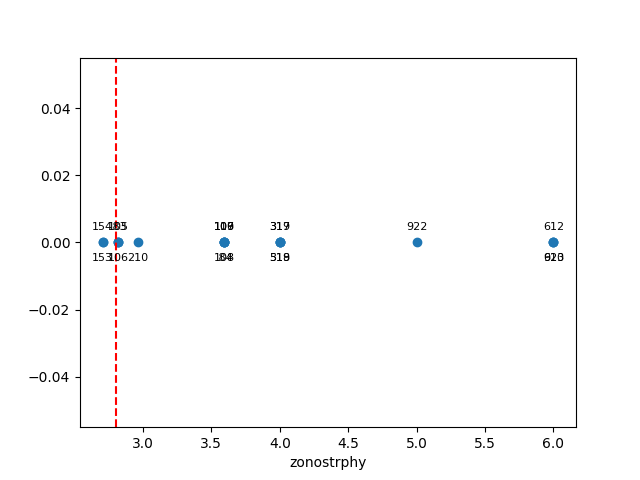

[2.70494977 2.70494977 2.81758509 2.81758509 2.81758509 2.96227541
 3.5927681  3.5927681  3.5927681  3.5927681  3.5927681  4.
 4.         4.         4.         5.         6.         6.
 6.00000182]


In [33]:
plt.figure()

# Plotting the scatter plot
plt.scatter(Z_tab, [0] * Z_tab.shape[0])

# Adding text above each point
for i, desc in enumerate(simu_name_tab):
    if i%2==0:

        plt.text(Z_tab[i], 0.006, desc[-3:], fontsize=8, ha='center', va='top')
    else:
        plt.text(Z_tab[i], -0.006, desc[-3:], fontsize=8, ha='center', va='bottom')

plt.xlabel('zonostrphy')

plt.axvline(x=2.8, color='r', linestyle='--')
plt.show()

print(np.sort(Z_tab))

# Parameters space

In [26]:
# x=Z_tab
# y=KbetaOL_tab

# plt.figure(figsize=(9,9))
# # Plotting the data with descriptions
# for i, desc in enumerate(simu_name_tab):
#     plt.scatter(x[i], y[i], label=desc)
#     plt.text(x[i], y[i], desc, fontsize=9, ha='left', va='bottom')


# plt.xlabel(r'$Z=L_{\beta r}/L_\epsilon$')
# plt.ylabel(r'$Oc=L_{\beta r}/L_x$')
# plt.yscale('log')

# plt.title('Espaces des paramètres de la simulation')
# plt.show()

['String 83' 'String 84' 'String 116' 'String 153' 'String 154'
 'String 210' 'String 317' 'String 318' 'String 319' 'String 519'
 'String 922' 'String 923' 'String 612' 'String 610' 'String 105'
 'String 106' 'String 107' 'String 108' 'String 109']


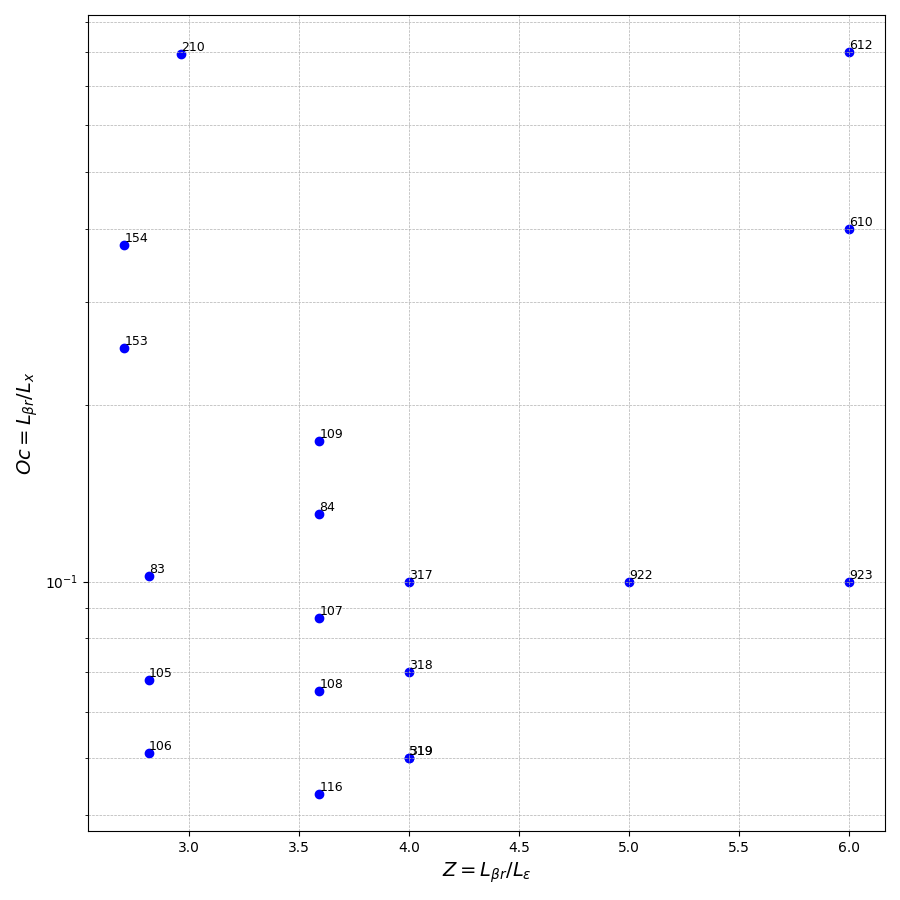

In [27]:
import matplotlib.pyplot as plt

# Assuming x, y, and simu_name_tab are already defined
x = Zo_tab_l
y = Oc_tab_l

plt.figure(figsize=(9, 9))
# Define the specific simu_name values that don't check the energy requirement
highlighted_simus = [207,301, 302, 303, 304, 305,306,307,85,321,320,611,313,314,315,316]
cool_simus=[317,318,319]
print(simu_name_tab)
# Plotting the data with descriptions
for i, desc in enumerate(simu_name_tab):
    simu_number = int(desc.split(' ')[-1])  # Extract the numerical part
    if simu_number in highlighted_simus:
        color = 'purple'
    else:
        color = 'blue'

    
    plt.scatter(x[i], y[i],color=color ,marker='o')  
    plt.text(x[i], y[i], simu_number, fontsize=9, ha='left', va='bottom')

# Labels and title
plt.xlabel(r'$Z=L_{\beta r}/L_\epsilon$', fontsize=14)
plt.ylabel(r'$Oc=L_{\beta r}/L_x$', fontsize=14)
plt.yscale('log')

#plt.title('Espaces des paramètres de la simulation', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout() 
plt.savefig('figures/Espace_param/param_space.png')
plt.show()


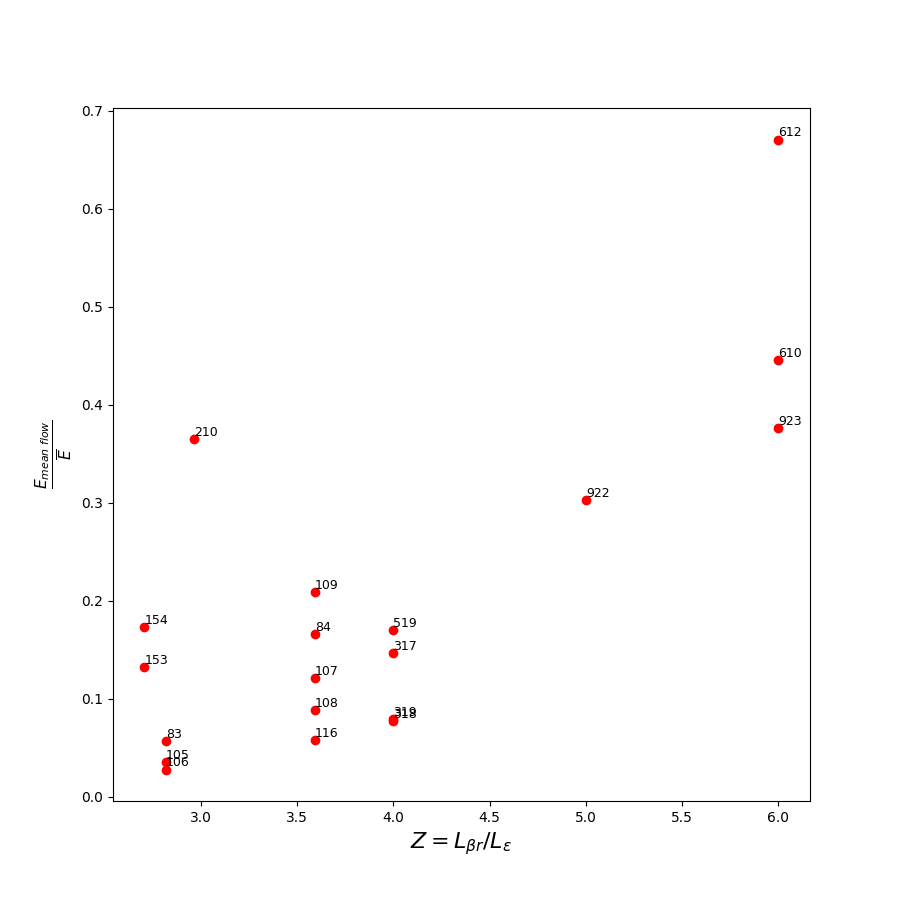

In [28]:
x=Zo_tab_l
y=E_zonal_tab
z=E_mean_tab

plt.figure(figsize=(9,9))
for i, desc in enumerate(simu_name_tab):
    simu_number = int(desc.split(' ')[-1])  # Extract the numerical part
    if simu_number in highlighted_simus:
        color = 'purple'
    elif simu_number==619:
        continue
    else:
        color = 'red'

    
    plt.scatter(x[i], y[i],color=color ,marker='o')  
    plt.text(x[i], y[i],simu_number, fontsize=9, ha='left', va='bottom')
    #plt.scatter(x[i], z[i],color='orange' ,marker='*')

# Add the legend labels only for the representative scatter plots
plt.scatter([], [], color='red', marker='o', label='zonal mean energy ratio')
plt.scatter([], [], color='orange', marker='*', label='energy of the mean flow ratio')
#plt.legend(loc='lower right')
#plt.title('Energie ratio with respect to the zonostrophy')
plt.xlabel(r'$Z=L_{\beta r}/L_\epsilon$',fontsize=16)
plt.ylabel(r'$\frac{E_{mean\ flow}}{\overline{E}}$',fontsize=16)
plt.savefig('figures/Energy_calc/E_zonal_bc'+str(bc_fac)+'.png')
plt.show()

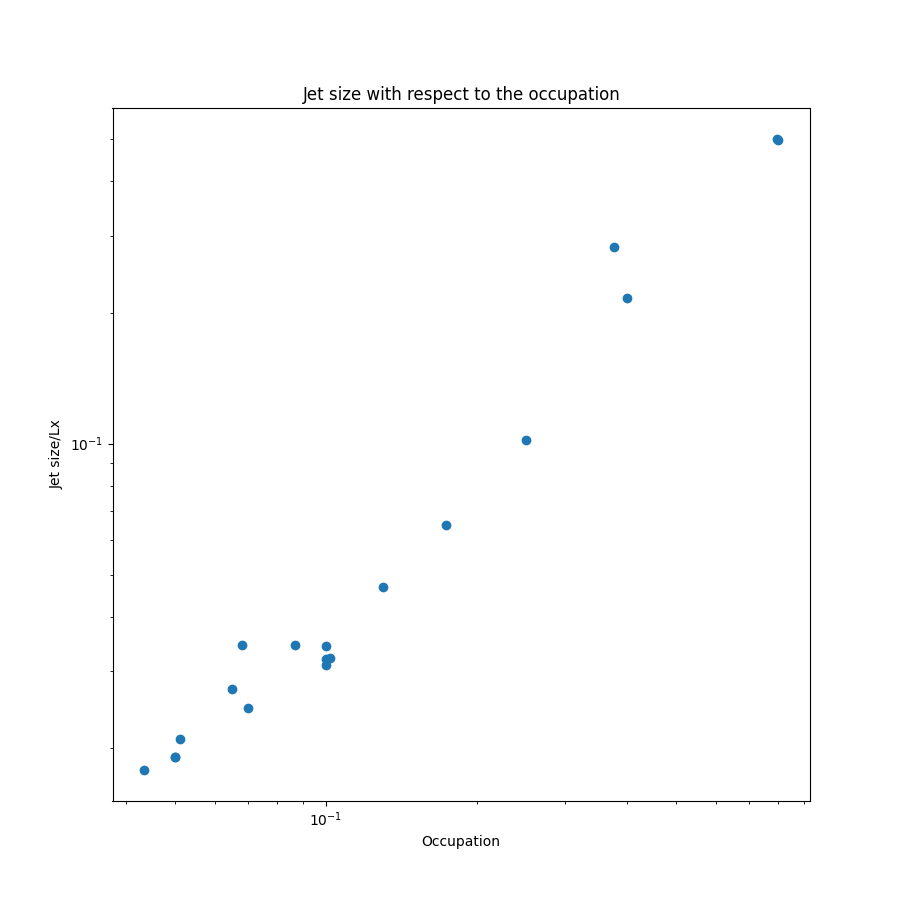

In [42]:
#Plotting the jet size VS occupation
x=Oc_tab_l
y=jet_size_tab/Lx_tab.astype(float)
#pol=np.polyfit(x,y,1)


plt.figure(figsize=(9,9))
plt.scatter(x,y,)
#plt.plot(x,pol[0]*x+pol[1],label='y='+str(pol[0])+'x+'+str(pol[1]),color='red')
plt.xlabel('Occupation')    
plt.ylabel('Jet size/Lx')
plt.loglog()
plt.title('Jet size with respect to the occupation')
plt.savefig('figures/jets/Jet_size_occupation.png')
plt.show()

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


<function matplotlib.pyplot.show(block=None)>

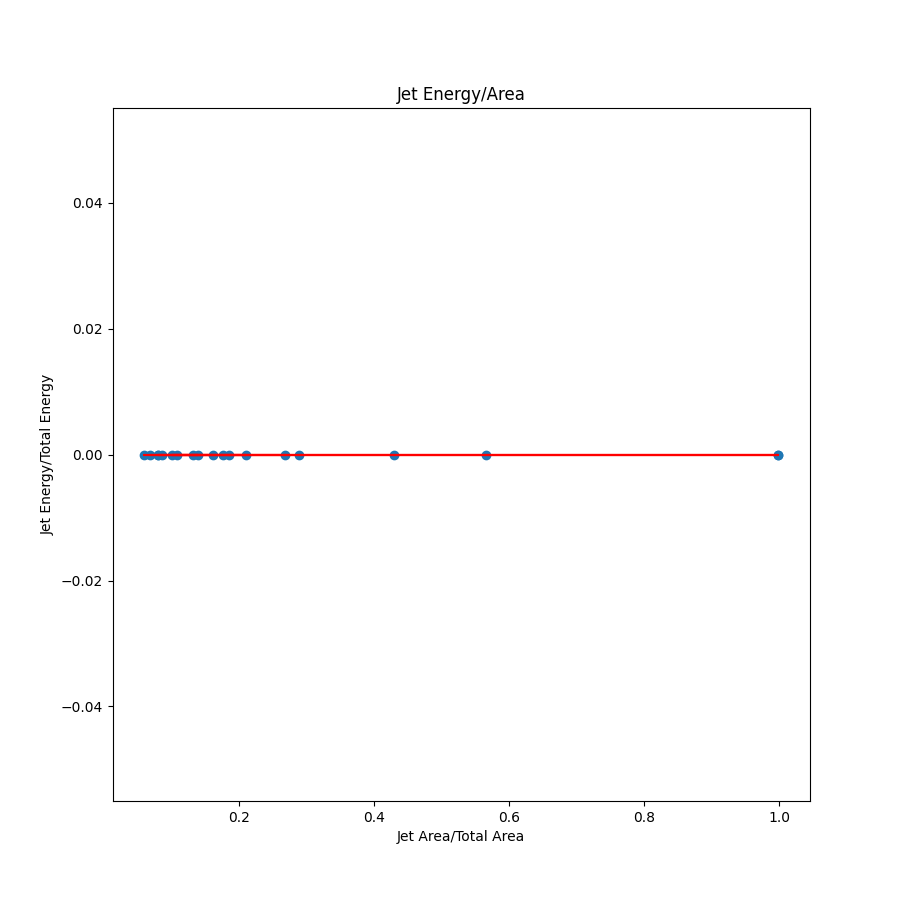

In [11]:
print(type(Lx_tab), type(jet_size_tab), type(Area_tot))
print(type(E_diss_jet), type(E_diss_tot))
x=Lx_tab.astype(float)*jet_size_tab/Area_tot#Area of the jets/total area

y=E_diss_jet/E_diss_tot #Energy dissipated by the jets/total energy dissipated

pol=np.polyfit(x,y,1)
plt.figure(figsize=(9,9))
plt.scatter(x,y)
plt.plot(x,pol[0]*x+pol[1],label='y='+str(pol[0])+'x+'+str(pol[1]),color='red')
plt.xlabel('Jet Area/Total Area')
plt.ylabel('Jet Energy/Total Energy')
plt.title('Jet Energy/Area')

plt.savefig('figures/Energy_calc/Energy_jet_area_bc'+str(bc_fac)+'.png')
plt.show

(19,) (19,) (19,)


/tmp/ipykernel_84422/3003254780.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(9,9))


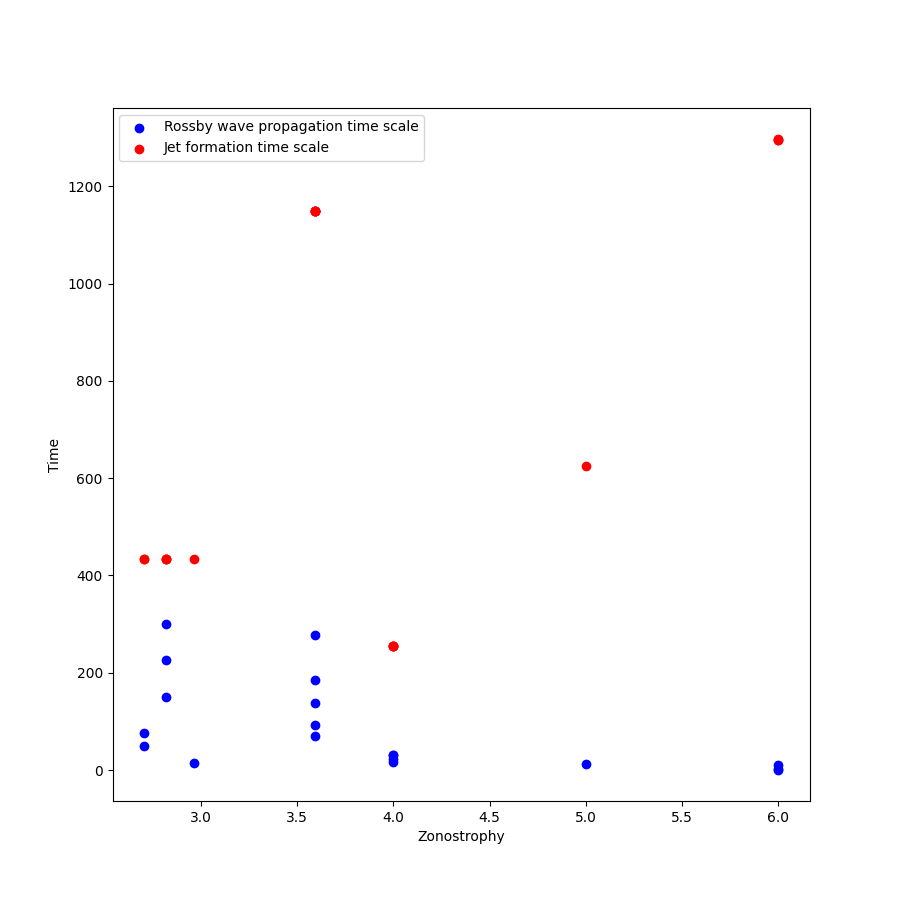

In [23]:
print(np.shape(simu_numbers),np.shape(time_jet),np.shape(time_nl))


x=Zo_tab_l
y=time_jet
z=time_nl   

plt.figure(figsize=(9,9))
# for i, desc in enumerate(simu_name_tab):
#     simu_number = int(desc.split(' ')[-1])  # Extract the numerical part
#     if simu_number in highlighted_simus:
#         color = 'purple'
#     elif simu_number==619:
#         continue
#     else:
#         color = 'red'

    
#     #plt.scatter(x[i], y[i],color=color ,marker='o')  
#     plt.text(x[i], y[i],simu_number, fontsize=9, ha='left', va='bottom')
#     plt.text(x[i], z[i],simu_number, fontsize=9, ha='left', va='bottom')
    #plt.scatter(x[i], z[i],color='orange' ,marker='*')
plt.scatter(Zo_tab_l,time_nl,color='blue',label='Rossby wave propagation time scale')
plt.scatter(Zo_tab_l,time_jet,color='red',label='Jet formation time scale')
plt.xlabel('Zonostrophy')
plt.ylabel('Time')
plt.legend()
# plt.title('Time scales')
plt.savefig('figures/Energy_calc/time_scale_bc'+str(bc_fac)+'.png')
plt.show()

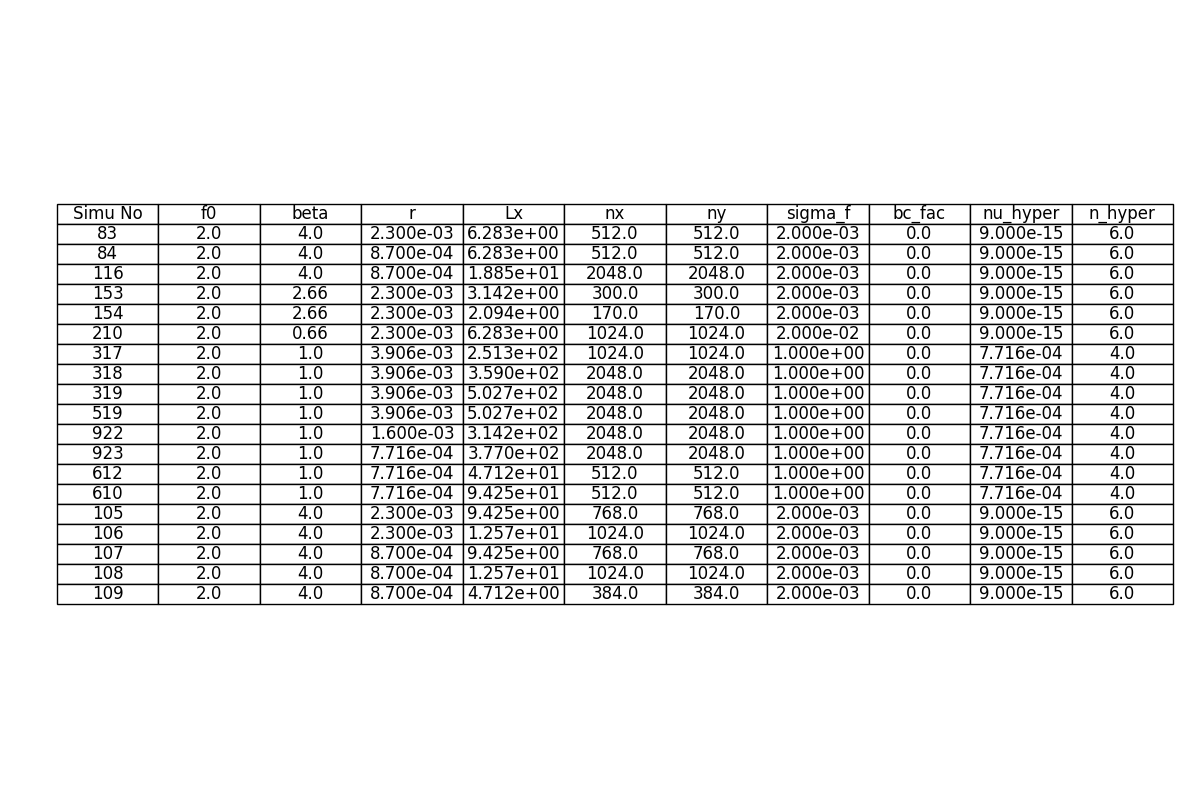

In [37]:

# Convert arrays to scientific notation with 3 significant figures
def to_sci_notation(arr):
    return np.array([f"{float(x):.3e}" for x in arr])
#f0_tab = to_sci_notation(f0_tab)
#beta_tab = to_sci_notation(beta_tab)
hEkb_tab = to_sci_notation(hEkb_tab)
dh_tab = to_sci_notation(dh_tab)
Lx_tab = to_sci_notation(Lx_tab)
#nx_tab = to_sci_notation(nx_tab)
#ny_tab = to_sci_notation(ny_tab)
sigma_f_tab = to_sci_notation(sigma_f_tab)
#bc_fac_tab = to_sci_notation(bc_fac_tab)
nu_hyper_tab = to_sci_notation(nu_hyper_tab)
#n_hyper_tab = to_sci_notation(n_hyper_tab)



# Create a DataFrame
data = {
    'Simu No': simu_numbers,
    'f0': f0_tab,
    'beta': beta_tab,
    'r': hEkb_tab,
    'Lx': Lx_tab,
    'nx': nx_tab,
    'ny': ny_tab,
    'sigma_f': sigma_f_tab,
    'bc_fac': bc_fac_tab,
    'nu_hyper': nu_hyper_tab,
    'n_hyper': n_hyper_tab
}

df = pd.DataFrame(data)

# Plot the DataFrame
fig, ax = plt.subplots(figsize=(12, 8))  # Adjust the size as needed
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
table.auto_set_font_size(False)
table.set_fontsize(12)
table.scale(1.2, 1.2)
# Save the table as a PNG image
plt.savefig('figures/simulation_parameters.png', bbox_inches='tight', pad_inches=0.1)
plt.show()